## Import

In [1]:
%pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=911897512bcb686ad29b403e4eeddc2025589b9e8aad2cadac5a98f3323e4c23
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=979b32bbe3887e292f4ca39956cbf894757f80d19df7a7c92bb5ee12651cb19e
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [2]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from typing import List, Union
from joblib import Parallel, delayed

import segmentation_models_pytorch as smp
import argparse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utils

In [3]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom dataset

In [4]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

## Data Loader

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive/data

Mounted at /content/drive
/content/drive/MyDrive/data


In [6]:
transform = A.Compose(
    [
        A.CenterCrop(224, 224),

        #A.HorizontalFlip(p = 0.5),

        #A.IAAAdditiveGaussianNoise(p=0.2),
        #A.IAAPerspective(p=0.5),

        #A.OneOf([
            #A.CLAHE(p=1),
            #A.RandomBrightness(p = 1),
            #A.RandomGamma(p = 1)
        #], p = 0.5),

        #A.OneOf([
            #A.IAASharpen(p = 1),
            #A.Blur(blur_limit=3, p=1),
            #A.GaussianBlur(p = 1),
            #A.MotionBlur(blur_limit=3, p=1),
            #A.GaussNoise(p = 1)
        #], p = 0.5),

        #A.OneOf([
            #A.RandomContrast(p=1),
            #A.HueSaturationValue(p=1),
        #], p = 0.5),

        #A.Resize(224, 224),

        A.Normalize(),
        ToTensorV2()
    ]
)

transform_test = A.Compose(
    [
        A.Resize(224, 224),

        A.Normalize(),
        ToTensorV2()
    ]
)

dataset = SatelliteDataset(csv_file='train.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

##Define Model

In [7]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'

model = smp.Unet(
    encoder_name = ENCODER,
    encoder_weights = ENCODER_WEIGHTS,
    in_channels = 3,
    classes = 1,
    activation = ACTIVATION,
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:05<00:00, 49.8MB/s]


##Model Train

In [ ]:
import segmentation_models_pytorch.utils

# loss function과 optimizer 정의
criterion = smp.utils.losses.DiceLoss()
#criterion = smp.losses.DiceLoss(mode = 'binary')

#optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001),])
#optimizer = torch.optim.SGD([dict(params=model.parameters(), lr=0.0001),])
optimizer = torch.optim.AdamW([dict(params=model.parameters(), lr=0.0001, weight_decay=0.001),])

# training loop
for epoch in range(20):  # 10 에폭 동안 학습합니다.
    model.train()
    model.to('cuda')
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')

  6%|▋         | 28/447 [02:44<31:50,  4.56s/it]

In [10]:
torch.save(model.state_dict(), 'weights_only.pth')

In [8]:
model.to('cuda')
model.load_state_dict(torch.load('weights_only.pth'))

<All keys matched successfully>

##Inference

In [9]:
test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform_test, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [10]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs = model(images)
        masks = outputs.cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8) # Threshold = 0.35

        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

  0%|          | 0/3790 [02:00<?, ?it/s]


error: ignored

##Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

In [ ]:
submit.to_csv('./submit.csv', index=False)

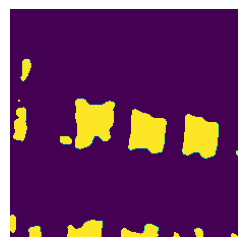

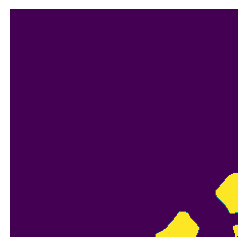

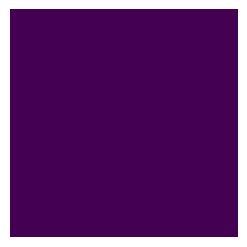

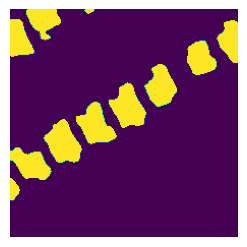

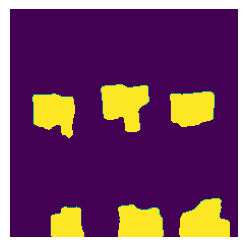

In [ ]:
test_data = pd.read_csv('test.csv')
submit = pd.read_csv('submit.csv')

import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

for i in range(5):

  test_mask = rle_decode(submit['mask_rle'][i], (224,224))


  plt.figure(figsize=(10,10))

  plt.subplot(132)
  plt.imshow(test_mask)
  plt.axis("off")